In [1]:
!pip install biopython
!pip install gget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 5.1 MB/s 
     |████████████████████████████████| 128 kB 54.0 MB/s 
     |████████████████████████████████| 25.2 MB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 41.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt; plt.rcdefaults()
import json
import gget

from datetime import datetime

from Bio import Entrez

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Task 1 – Map the gene-symbol for every gene in the SFARI gene list to an NCBI UID (unique Entrez Gene identifier) (2 marks).

In [11]:
sfari_genes_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/SFARI-Gene_genes_11-07-2022release_11-09-2022export.csv"

NameError: ignored

In [14]:
def fetch_id(gene):
    gene = gene + '[gene] AND "Homo sapiens"[Organism]'
    Entrez.email = 's1873532@ed.ac.uk'
    handle = Entrez.esearch(db='gene',
                            sort='relevance',
                            retmax='999999999',
                            retmode='xml',
                            term=gene)
    results = Entrez.read(handle)
    if len(results["IdList"]) > 0:
      return results["IdList"][0]
    else:
      print(gene + " not found")
      return None


sfari_genes = pd.read_csv(sfari_genes_path)

# print(sfari_genes[["gene-symbol", "ensembl-id"]].iloc[0])
# print(gget.info(sfari_genes["ensembl-id"][0]))
# print(gget.info(sfari_genes["ensembl-id"][0]).columns)

# Make list of all the ENSMBL ids
genes = sfari_genes['gene-symbol']

try:
  to_merge = pd.read_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/to_merge_ncbi_ids.csv", index_col=0)
except:
  to_merge = pd.DataFrame(columns=['gene-symbol','ncbi-id'])

print(to_merge.shape)

cond = genes.isin(to_merge['gene-symbol'])
genes.drop(genes[cond].index, inplace=True)

for gene in genes:
  # print(gene)
  ncbi_id = fetch_id(gene)
  to_merge = to_merge.append({"gene-symbol":gene, "ncbi-id":ncbi_id}, ignore_index=True)

  to_merge.to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/to_merge_ncbi_ids.csv")


(991, 2)


In [23]:
#@title
print(to_merge.shape)
# print(to_merge.head)

# print(sfari_genes.head)

to_merge.loc[to_merge["gene-symbol"] == "MSNP1AS", ["ncbi-id"]] = 4479
to_merge.loc[to_merge["gene-symbol"] == "RP11-1407O15.2",["ncbi-id"]] = 26121
to_merge.loc[to_merge["gene-symbol"] == "RPS10P2-AS1",["ncbi-id"]] = 140758

print(to_merge.loc[to_merge["gene-symbol"] == "MSNP1AS"])

dropped = to_merge.dropna()

print(dropped)

# dropped["gene-symbol"] = dropped["gene-symbol"].astype(str)
# dropped["ncbi-id"] = dropped["ncbi-id"].astype(int)
# print(dropped.dtypes)
# print(dropped.loc[dropped["gene-symbol"] == "RP11-1407O15.2"])

print(dropped.shape)

print(sfari_genes.dtypes)
print(dropped.dtypes)

sfari_genes2 = sfari_genes.join(dropped.set_index("gene-symbol"), on="gene-symbol", how="inner")

# Merge back with the full dataset
# sfari_genes.join(genes, on="ensembl-id")
# print(sfari_genes2.shape)
# print(sfari_genes2.columns)
# print(sfari_genes2.head)

(1095, 2)
    gene-symbol ncbi-id
620     MSNP1AS    4479
     gene-symbol   ncbi-id
0           ABAT      18.0
1         ABCA10   10349.0
2         ABCA13  154664.0
3          ABCA7   10347.0
4            ACE    1636.0
...          ...       ...
1090      ZNF774    342132
1091     ZNF804A     91752
1092      ZNF827    152485
1093      ZSWIM6     57688
1094      ZWILCH     55055

[1095 rows x 2 columns]
(1095, 2)
status                 int64
gene-symbol           object
gene-name             object
ensembl-id            object
chromosome            object
genetic-category      object
gene-score           float64
syndromic              int64
eagle                float64
number-of-reports      int64
dtype: object
gene-symbol    object
ncbi-id        object
dtype: object


Task 2 – Using the gene2go file from NCBI that we worked with in week 6 find the Gene Ontology terms that have been annotated to all of the SFARI genes (4marks).

In [24]:
gene2go_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go"

gene2go = pd.read_csv(gene2go_path, sep="\t")
gene2go.rename(columns={"GeneID":"ncbi-id"}, inplace=True)

In [25]:
trimmed_sfari = sfari_genes2
trimmed_sfari = trimmed_sfari[["gene-symbol", "gene-score", "syndromic", "ncbi-id"]]
trimmed_sfari["ncbi-id"] = trimmed_sfari["ncbi-id"].astype(int)

# print(gene2go.columns)
# print(trimmed_sfari.columns)

print(gene2go.shape)
print(trimmed_sfari.shape)

# print(trimmed_sfari.set_index("ncbi-id").head)

gene2go_trimmed = gene2go.join(trimmed_sfari.set_index("ncbi-id"), on="ncbi-id", how="inner")

print(gene2go_trimmed.columns)
print(gene2go_trimmed.shape)

print(gene2go_trimmed.head)

(2368399, 8)
(1095, 4)
Index(['#tax_id', 'ncbi-id', 'GO_ID', 'Evidence', 'Qualifier', 'GO_term',
       'PubMed', 'Category', 'gene-symbol', 'gene-score', 'syndromic'],
      dtype='object')
(31125, 11)
<bound method NDFrame.head of          #tax_id    ncbi-id       GO_ID Evidence       Qualifier  \
811414      9606         18  GO:0001666      IEA     involved_in   
811415      9606         18  GO:0003867      IDA  contributes_to   
811416      9606         18  GO:0005739      IBA    is_active_in   
811417      9606         18  GO:0005739      IDA      located_in   
811418      9606         18  GO:0005739      ISS      located_in   
...          ...        ...         ...      ...             ...   
1156174     9606     729092  GO:0005096      IBA         enables   
1156175     9606     729092  GO:0046872      IEA         enables   
1156176     9606     729092  GO:0090630      IBA     involved_in   
1157240     9606  100128977  GO:0031047      IMP     involved_in   
1157241     9606  1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# print(trimmed_sfari)

gene2go_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go"

gene2go = pd.read_csv(gene2go_path, sep="\t")
gene2go.rename(columns={"GeneID":"ncbi-id"}, inplace=True)

In [ ]:
rest = gene2go["GO_term"].unique()
print(rest.shape)

for gene in trimmed_sfari["ncbi-id"]:
  # rest = rest.join(trimmed_sfari.set_index("ncbi-id"), on="ncbi-id", how="right")

  gos = gene2go[gene2go["ncbi-id"] == gene]["GO_term"].unique()

  print(gos.shape)

  rest = np.intersect1d(rest, gos)

  print(rest.shape)

(27500,)
(38,)
(38,)
(8,)
(0,)
(14,)
(0,)
(49,)
(0,)
(89,)
(0,)
(37,)
(0,)
(52,)
(0,)
(67,)
(0,)
(20,)
(0,)
(21,)
(0,)
(17,)
(0,)
(39,)
(0,)
(18,)
(0,)
(17,)
(0,)
(12,)
(0,)
(9,)
(0,)
(26,)
(0,)
(19,)
(0,)
(8,)
(0,)
(28,)
(0,)
(34,)
(0,)
(30,)
(0,)
(98,)
(0,)
(35,)
(0,)
(7,)
(0,)
(19,)
(0,)
(9,)
(0,)
(34,)
(0,)
(38,)
(0,)
(27,)
(0,)
(11,)
(0,)
(8,)
(0,)
(9,)
(0,)
(7,)
(0,)
(71,)
(0,)
(57,)
(0,)
(17,)
(0,)
(4,)
(0,)
(53,)
(0,)
(29,)
(0,)
(29,)
(0,)
(24,)
(0,)
(9,)
(0,)
(7,)
(0,)
(10,)
(0,)
(90,)
(0,)
(17,)
(0,)
(16,)
(0,)
(32,)
(0,)
(27,)
(0,)
(10,)
(0,)
(17,)
(0,)
(15,)
(0,)
(13,)
(0,)
(9,)
(0,)
(26,)
(0,)
(22,)
(0,)
(26,)
(0,)
(76,)
(0,)
(55,)
(0,)
(20,)
(0,)
(20,)
(0,)
(41,)
(0,)
(30,)
(0,)
(6,)
(0,)
(3,)
(0,)
(32,)
(0,)
(13,)
(0,)
(27,)
(0,)
(16,)
(0,)
(8,)
(0,)
(83,)
(0,)
(17,)
(0,)
(52,)
(0,)
(44,)
(0,)
(46,)
(0,)
(66,)
(0,)
(23,)
(0,)
(48,)
(0,)
(16,)
(0,)
(40,)
(0,)
(19,)
(0,)
(6,)
(0,)
(71,)
(0,)
(3,)
(0,)
(15,)
(0,)
(20,)
(0,)
(26,)
(0,)
(59,)
(0,)
(52,)
(0,)
(27,)
(0,)
(26,)


Task 3 – Now split the genes up into three lists by their SFARI gene-score (1 mark).

In [39]:
gene2go_trimmed["GO_description"] = gene2go_trimmed["Qualifier"] + " " + gene2go_trimmed["GO_term"]

gene2go_score_1 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 1]
gene2go_score_2 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 2]
gene2go_score_3 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 3]

gene2go_score_1_list = gene2go_score_1["ncbi-id"].unique()
np.savetxt("/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go_score_1_list.csv", gene2go_score_1_list, fmt="GeneID:%i", delimiter=",")
np.savetxt("/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go_score_1_list_string.csv", gene2go_score_1_list, fmt="%i", delimiter=",")

gene2go_score_2_list = gene2go_score_2["ncbi-id"].unique()
np.savetxt("/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go_score_2_list.csv", gene2go_score_2_list, fmt="GeneID:%i", delimiter=",")

gene2go_score_3_list = gene2go_score_3["ncbi-id"].unique()
np.savetxt("/content/drive/MyDrive/Bioinformatics/coursework 2/gene2go_score_3_list.csv", gene2go_score_3_list, fmt="GeneID:%i", delimiter=",")

print(gene2go_trimmed.shape)
print(gene2go_score_1.shape)
print(gene2go_score_2.shape)
print(gene2go_score_3.shape)

print("Score 1")
gene2go_score_1 = gene2go_score_1[["GO_ID", "GO_term"]].value_counts(dropna = False).to_frame()
print(gene2go_score_1.shape)
print(gene2go_score_1[0:10])
gene2go_score_1[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_1_terms.txt", sep="&", line_terminator="\\\\ \r\n")

print("Score 2")
gene2go_score_2 = gene2go_score_2[["GO_ID", "GO_term"]].value_counts(dropna = False).to_frame()
print(gene2go_score_2.shape)
print(gene2go_score_2[0:10])
gene2go_score_2[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_2_terms.txt", sep="&", line_terminator="\\\\ \r\n")

print("Score 3")
gene2go_score_3 = gene2go_score_3[["GO_ID", "GO_term"]].value_counts(dropna = False).to_frame()
print(gene2go_score_3.shape)
print(gene2go_score_3[0:10])
gene2go_score_3[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_3_terms.txt", sep="&", line_terminator="\\\\ \r\n")

# We construct the description from terma nd qualifier, because we shouldnt group things like "in nucleus" and "not in nucleus"

gene2go_score_1 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 1]
gene2go_score_2 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 2]
gene2go_score_3 = gene2go_trimmed.loc[gene2go_trimmed["gene-score"] == 3]

print("Score 1")
gene2go_score_1 = gene2go_score_1[["GO_ID", "GO_description"]].value_counts(dropna = False).to_frame()
print(gene2go_score_1.shape)
print(gene2go_score_1[0:10])
gene2go_score_1[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_1_tuples.txt", sep="&", line_terminator="\\\\ \r\n")

print("Score 2")
gene2go_score_2 = gene2go_score_2[["GO_ID", "GO_description"]].value_counts(dropna = False).to_frame()
print(gene2go_score_2.shape)
print(gene2go_score_2[0:10])
gene2go_score_2[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_2_tuples.txt", sep="&", line_terminator="\\\\ \r\n")

print("Score 3")
gene2go_score_3 = gene2go_score_3[["GO_ID", "GO_description"]].value_counts(dropna = False).to_frame()
print(gene2go_score_3.shape)
print(gene2go_score_3[0:10])
gene2go_score_2[0:10].to_csv("/content/drive/MyDrive/Bioinformatics/coursework 2/top10_score_3_tuples.txt", sep="&", line_terminator="\\\\ \r\n")

(31125, 12)
(7508, 12)
(18170, 12)
(2657, 12)
Score 1
(2604, 1)
                                                                 0
GO_ID      GO_term                                                
GO:0005634 nucleus                                             176
GO:0005515 protein binding                                     170
GO:0005654 nucleoplasm                                         141
GO:0005886 plasma membrane                                     116
GO:0005829 cytosol                                             105
GO:0005737 cytoplasm                                            84
GO:0045944 positive regulation of transcription by RNA pol...   73
GO:0016020 membrane                                             55
GO:0006357 regulation of transcription by RNA polymerase II     55
GO:0000122 negative regulation of transcription by RNA pol...   53
Score 2
(5122, 1)
                                    0
GO_ID      GO_term                   
GO:0005886 plasma membrane        498


Task 5 – Take the three lists of UIDs created above and use the PantherDB tool - http://pantherdb.org/ to perform a “Functional classification viewed in graphic charts” analysis reporting and select the “Bar chart” display option, using default settings. Once on the results page displaying the bar chart use the pull-down menu to change the ontology to “Biological Process”. Click the small (!) “export” button to download the results as a text file and use this to make your own bar chart (5 marks).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


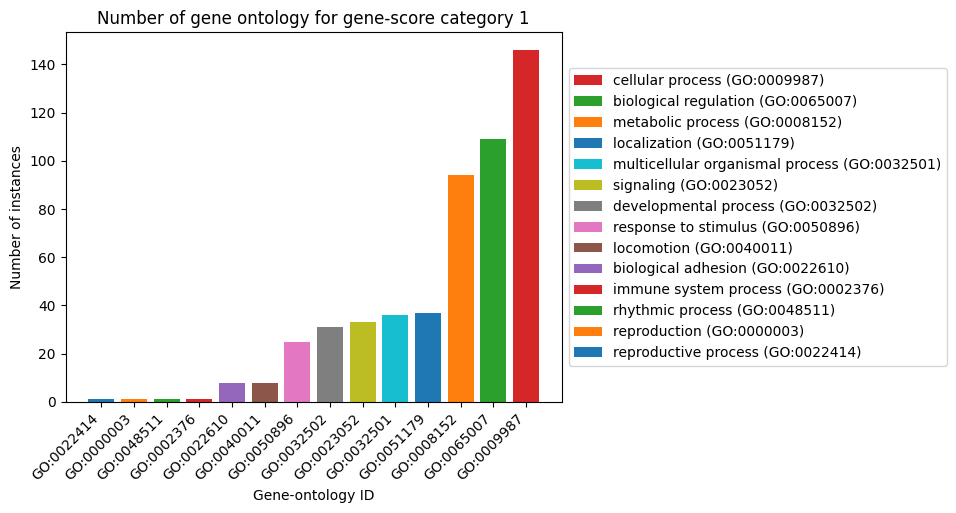

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


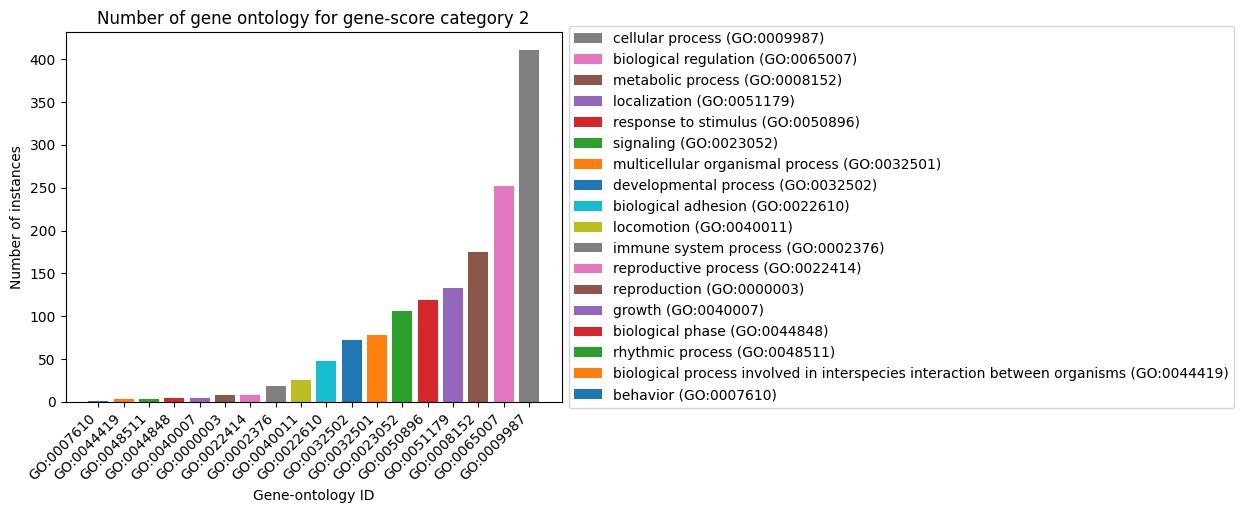

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


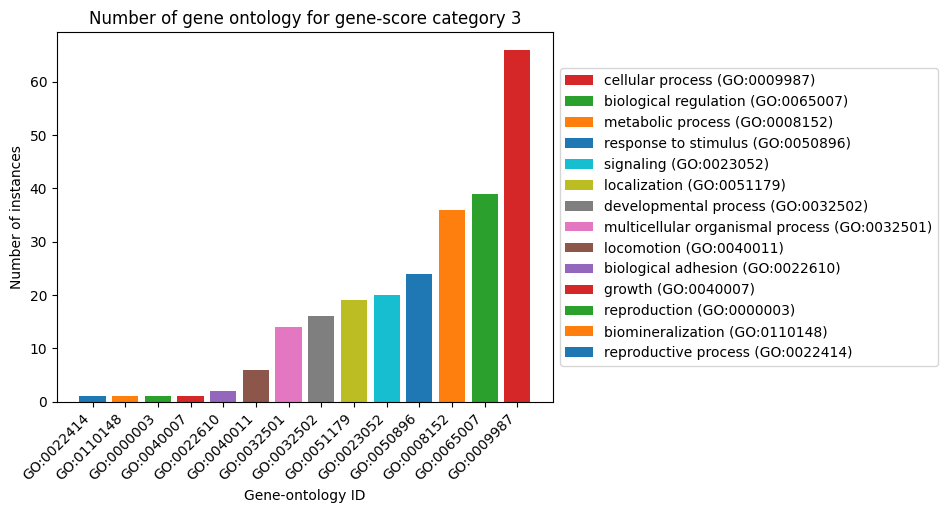

In [38]:
# Since these masochistic twats didnt bother including them in teh data download
pantherdb_headers = ["Category name (Accession)", "# genes", "Percent of gene hit against total # genes", "Percent of gene hit against total # Process hits"]

pantherdb_gene_score_1_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/pantherChart_score_1.txt"
pantherdb_gene_score_1 = pd.read_csv(pantherdb_gene_score_1_path, sep="\t", names=pantherdb_headers)
split = pantherdb_gene_score_1["Category name (Accession)"].str.split("(", n = 1, expand = True)
# print(split.head)
pantherdb_gene_score_1["Category name"] = split[0]
pantherdb_gene_score_1["(Accession)"] = split[1].str.replace(")", "")
pantherdb_gene_score_1.sort_values("# genes", inplace=True)

# print(pantherdb_gene_score_1.head)

fig, ax = plt.subplots()

for i in range(0, len(pantherdb_gene_score_1["(Accession)"])):
  ax.bar(pantherdb_gene_score_1["(Accession)"].iloc[i], pantherdb_gene_score_1["# genes"].iloc[i], align='center', label=pantherdb_gene_score_1["Category name (Accession)"].iloc[i])

ax.set_ylabel('Number of instances')
ax.set_xlabel('Gene-ontology ID')
ax.set_title('Number of gene ontology for gene-score category 1')
ax.set_xticklabels(pantherdb_gene_score_1["(Accession)"], rotation = 45,  ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



pantherdb_gene_score_2_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/pantherChart_score_2.txt"
pantherdb_gene_score_2 = pd.read_csv(pantherdb_gene_score_2_path, sep="\t", names=pantherdb_headers)
split = pantherdb_gene_score_2["Category name (Accession)"].str.split("(", n = 1, expand = True)
pantherdb_gene_score_2["Category name"] = split[0]
pantherdb_gene_score_2["(Accession)"] = split[1].str.replace(")", "")
pantherdb_gene_score_2.sort_values("# genes", inplace=True)

fig, ax = plt.subplots()

for i in range(0, len(pantherdb_gene_score_2["(Accession)"])):
  ax.bar(pantherdb_gene_score_2["(Accession)"].iloc[i], pantherdb_gene_score_2["# genes"].iloc[i], align='center', label=pantherdb_gene_score_2["Category name (Accession)"].iloc[i])

ax.set_ylabel('Number of instances')
ax.set_xlabel('Gene-ontology ID')
ax.set_title('Number of gene ontology for gene-score category 2')
ax.set_xticklabels(pantherdb_gene_score_2["(Accession)"], rotation = 45,  ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




pantherdb_gene_score_3_path = "/content/drive/MyDrive/Bioinformatics/coursework 2/pantherChart_score_3.txt"
pantherdb_gene_score_3 = pd.read_csv(pantherdb_gene_score_3_path, sep="\t", names=pantherdb_headers)
split = pantherdb_gene_score_3["Category name (Accession)"].str.split("(", n = 1, expand = True)
pantherdb_gene_score_3["Category name"] = split[0]
pantherdb_gene_score_3["(Accession)"] = split[1].str.replace(")", "")
pantherdb_gene_score_3.sort_values("# genes", inplace=True)

fig, ax = plt.subplots()

for i in range(0, len(pantherdb_gene_score_3["(Accession)"])):
  ax.bar(pantherdb_gene_score_3["(Accession)"].iloc[i], pantherdb_gene_score_3["# genes"].iloc[i], align='center', label=pantherdb_gene_score_3["Category name (Accession)"].iloc[i])

ax.set_ylabel('Number of instances')
ax.set_xlabel('Gene-ontology ID')
ax.set_title('Number of gene ontology for gene-score category 3')
ax.set_xticklabels(pantherdb_gene_score_3["(Accession)"], rotation = 45,  ha="right")
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()